In [250]:
from skimage import io, transform
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
from dataLoader import OrganoidDataset
from torch.utils import data
import numpy as np
import sys
import pandas as pd
from imageio import imread
from PIL import Image

from dataLoader import OrganoidDataset
from conv_model import SimpleConvNet
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
          'shuffle': True, 'num_workers' : 2}
max_epochs = 100

In [3]:
use_cuda

True

In [233]:
figure_path = '../milestoneReport/figures/'

# load data

In [4]:

import pandas 
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

params = {'batch_size': 100, # low for testing
  'shuffle': True, 'num_workers' : 4}

max_epochs = 100

path = '../data/CS231n_Tim_Shan_example_data/'
well_descriptions = pandas.read_csv('filtered_well_descriptions.txt', header=0)
day1wells = well_descriptions['well_id']
day1wells = day1wells[well_descriptions['day'] == 1]
day1wells.shape
day13wells = well_descriptions['well_id']
day13wells = day13wells[well_descriptions['day'] == 13]
day13wells.shape
daysLabel = pandas.Series(list(set(day13wells) & set(day1wells)))


well_labels = []
for i in range(daysLabel.shape[0]):
  i2str = str(daysLabel[i])
  if len(i2str) == 1:
    i2str = '000' + i2str
  if len(i2str) == 2:
    i2str = '00' + i2str
  if len(i2str) == 3:
    i2str = '0' + i2str
  well_labels.append(i2str)

day_label_X = ['01']*len(well_labels)
n = len(well_labels)

finalSizes = well_descriptions['hyst2_area']
finalSizes = finalSizes[np.logical_and(well_descriptions['day'] == 13, np.isin(well_descriptions['well_id'], daysLabel))].values

day1_mean_and_var = pandas.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels[:100], day_label_X = day_label_X[:100], Y = finalSizes[:100], intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
training_generator = data.DataLoader(initial_train_set, **params)


In [130]:
finalSizes.shape

(4642,)

In [131]:
well_descriptions['hyst2_area'].shape

(64775,)

In [133]:
len(well_labels)

4642

In [138]:
well_labels

['0000',
 '0001',
 '0002',
 '0003',
 '0004',
 '0005',
 '0006',
 '0007',
 '0008',
 '0009',
 '0010',
 '0011',
 '0012',
 '0013',
 '0014',
 '0015',
 '0016',
 '0017',
 '0018',
 '0019',
 '0020',
 '0021',
 '0022',
 '0023',
 '0024',
 '0025',
 '0026',
 '0027',
 '0028',
 '0029',
 '0030',
 '0031',
 '0032',
 '0033',
 '0034',
 '0035',
 '0036',
 '0037',
 '0038',
 '0039',
 '0040',
 '0041',
 '0043',
 '0044',
 '0045',
 '0046',
 '0047',
 '0048',
 '0049',
 '0050',
 '0051',
 '0052',
 '0053',
 '0054',
 '0055',
 '0056',
 '0057',
 '0058',
 '0059',
 '0060',
 '0061',
 '0062',
 '0063',
 '0064',
 '0065',
 '0066',
 '0067',
 '0068',
 '0069',
 '0070',
 '0071',
 '0072',
 '0073',
 '0074',
 '0075',
 '0076',
 '0077',
 '0078',
 '0079',
 '0080',
 '0081',
 '0082',
 '0083',
 '0084',
 '0085',
 '0086',
 '0087',
 '0088',
 '0089',
 '0090',
 '0091',
 '0092',
 '0093',
 '0095',
 '0096',
 '0097',
 '0098',
 '0099',
 '0100',
 '0101',
 '0102',
 '0103',
 '0104',
 '0105',
 '0106',
 '0107',
 '0108',
 '0109',
 '0110',
 '0111',
 '0112',
 

In [136]:
well_descriptions

(64775, 9)

In [8]:
TOTAL = 100

In [135]:
len(day1wells)

4721

In [71]:
initial_val_set = OrganoidDataset(path2files = path, well_labels = well_labels[100:200], day_label_X = day_label_X[100:200], Y = finalSizes[100:200], intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
validation_generator = data.DataLoader(initial_val_set, **params)


# preprocess data 
(ignore this part)

In [5]:
label_path = '../data/well_summary_A1_e0891BSA_all.csv'

In [6]:
label = pd.read_csv(label_path)

In [7]:
new_columns = ['well_id','day','median_pixel_intensity','mw_area_shape','original_hyst1_area','original_hyst2_area']
label.columns = new_columns

In [8]:
def get_image_name(well_id,day_id):
    image_name = 'well'+str(well_id).zfill(4)+'_day'+str(day_id).zfill(2)+'_well.png'
    return image_name
def get_well_label(well_id):
    return str(well_id).zfill(4)

In [9]:
label['image_name'] = label[['well_id','day']].apply(lambda x: get_image_name(*x),axis=1)
label['well_label'] = label['well_id'].apply(lambda x: get_well_label(x))

In [10]:
label.head(2)

,well_id,day,median_pixel_intensity,mw_area_shape,original_hyst1_area,original_hyst2_area,image_name,well_label
0,0,0,125.0,7830,512,418,well0000_day00_well.png,0000
1,1,0,125.0,8265,3044,3008,well0001_day00_well.png,0001


In [11]:
label.query("mw_area_shape > 32000").sort_values(by=['well_id','day'])

,well_id,day,median_pixel_intensity,mw_area_shape,original_hyst1_area,original_hyst2_area,image_name,well_label
43203,3,9,133.0,33124,14317,13965,well0003_day09_well.png,0003
33605,5,7,144.0,33124,14895,14654,well0005_day07_well.png,0005
48005,5,10,132.0,33124,12929,12666,well0005_day10_well.png,0005
57605,5,12,135.0,33124,13279,12997,well0005_day12_well.png,0005
19207,7,4,132.0,33124,14855,14586,well0007_day04_well.png,0007
43223,23,9,133.0,33124,17816,17288,well0023_day09_well.png,0023
33625,25,7,144.0,33124,20824,19976,well0025_day07_well.png,0025
43225,25,9,127.0,33124,23727,23129,well0025_day09_well.png,0025
52825,25,11,128.0,33124,29729,29134,well0025_day11_well.png,0025
14430,30,3,143.0,33124,13660,13486,well0030_day03_well.png,0030


In [12]:
excluded_well_id = set(label.query("mw_area_shape >= 32000")['well_id'].tolist())

In [13]:
len(excluded_well_id)

1510

In [14]:
label.isin(excluded_well_id).shape

(67200, 8)

In [15]:
corrected_labels = label.query("mw_area_shape < 32000")

In [16]:
# def normalize_label()

In [17]:
# corrected_labels['hyst1_area'] = corrected_labels['original_hyst1_area']/(corrected_labels['original_hyst1_area'].std())
# corrected_labels['hyst2_area'] = corrected_labels['original_hyst2_area']/(corrected_labels['original_hyst2_area'].std())

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
# corrected_labels.to_csv('filtered_well_descriptions.txt')

In [18]:
day1wells = corrected_labels.query("day == 1")
day13wells = corrected_labels.query("day == 13")

In [19]:
day1wells.shape, day13wells.shape

((4721, 10), (4712, 10))

In [20]:
merged_days = day1wells.merge(day13wells, on=['well_label'],suffixes=['_1','_13'])

In [21]:
merged_days.shape

(4642, 19)

In [98]:
merged_days

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,hyst1_area_1,hyst2_area_1,well_id_13,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst1_area_13,hyst2_area_13
0,0,1,141.0,7990,434,234,well0000_day01_well.png,0000,0.404609,0.229929,0,13,141.0,7216,1317,1095,well0000_day13_well.png,1.227811,1.075948
1,1,1,142.0,7482,39,0,well0001_day01_well.png,0001,0.036359,0.000000,1,13,140.0,7482,2125,1995,well0001_day13_well.png,1.981093,1.960289
2,2,1,143.0,7395,26,0,well0002_day01_well.png,0002,0.024239,0.000000,2,13,140.0,7568,849,667,well0002_day13_well.png,0.791505,0.655395
3,3,1,146.0,7396,392,315,well0003_day01_well.png,0003,0.365453,0.309519,3,13,142.0,7568,648,353,well0003_day13_well.png,0.604117,0.346858
4,4,1,147.0,7830,85,0,well0004_day01_well.png,0004,0.079244,0.000000,4,13,141.0,7654,179,0,well0004_day13_well.png,0.166878,0.000000
5,5,1,147.0,9167,493,375,well0005_day01_well.png,0005,0.459614,0.368475,5,13,141.0,7310,1387,1282,well0005_day13_well.png,1.293071,1.259695
6,6,1,145.0,7744,46,0,well0006_day01_well.png,0006,0.042885,0.000000,6,13,140.0,7396,602,496,well0006_day13_well.png,0.561232,0.487370
7,7,1,145.0,7568,106,0,well0007_day01_well.png,0007,0.098822,0.000000,7,13,140.0,7224,1197,1025,well0007_day13_well.png,1.115938,1.007166
8,8,1,146.0,7568,25,0,well0008_day01_well.png,0008,0.023307,0.000000,8,13,137.0,7308,863,763,well0008_day13_well.png,0.804557,0.749725
9,9,1,147.0,7656,22,0,well0009_day01_well.png,0009,0.020510,0.000000,9,13,135.0,7224,273,148,well0009_day13_well.png,0.254512,0.145425


In [100]:
merged_days = merged_days.sample(frac=1).reset_index(drop=True)

In [135]:
size_std = merged_days['original_hyst2_area_13'].std()

In [136]:
merged_days['hyst2_area_13'] = merged_days['original_hyst2_area_13']/size_std 

In [139]:
merged_days

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,hyst1_area_1,hyst2_area_1,well_id_13,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst1_area_13,hyst2_area_13
0,191,1,149.0,8091,18,0,well0191_day01_well.png,0191,0.016781,0.000000,191,13,140.0,7310,51,0,well0191_day13_well.png,0.047546,0.000000
1,1838,1,120.0,9408,43,0,well1838_day01_well.png,1838,0.040088,0.000000,1838,13,126.0,8648,5531,4356,well1838_day13_well.png,5.156435,3.425336
2,3834,1,106.0,8099,184,0,well3834_day01_well.png,3834,0.171539,0.000000,3834,13,130.0,8366,128,87,well3834_day13_well.png,0.119332,0.068412
3,2506,1,120.0,8008,15,0,well2506_day01_well.png,2506,0.013984,0.000000,2506,13,132.0,8464,25,0,well2506_day13_well.png,0.023307,0.000000
4,1812,1,125.0,8640,1777,1612,well1812_day01_well.png,1812,1.656660,1.583953,1812,13,135.0,7221,1801,1567,well1812_day13_well.png,1.679034,1.232209
5,4519,1,116.0,8554,392,370,well4519_day01_well.png,4519,0.365453,0.363562,4519,13,128.0,9384,614,330,well4519_day13_well.png,0.572419,0.259495
6,2726,1,119.0,8277,9,0,well2726_day01_well.png,2726,0.008391,0.000000,2726,13,129.0,9844,207,0,well2726_day13_well.png,0.192982,0.000000
7,556,1,142.0,7304,50,0,well0556_day01_well.png,0556,0.046614,0.000000,556,13,139.0,7304,181,0,well0556_day13_well.png,0.168742,0.000000
8,4760,1,117.0,9306,505,103,well4760_day01_well.png,4760,0.470801,0.101208,4760,13,127.0,8184,701,198,well4760_day13_well.png,0.653528,0.155697
9,3934,1,91.0,10816,843,291,well3934_day01_well.png,3934,0.785911,0.285937,3934,13,104.0,9212,207,0,well3934_day13_well.png,0.192982,0.000000


In [140]:
well_labels = merged_days['well_label']
finalSizes = merged_days['hyst2_area_13']

In [102]:
# for i in range(4800):
#     well_labels.append(str(i).zfill(4))

In [141]:
NUM_TRAIN = 100
#TOTAL = merged_days.shape[0]
#NUM_VAL = TOTAL-NUM_TRAIN
NUM_VAL = 100

In [142]:
training_set = merged_days[:NUM_TRAIN]
val_set = merged_days[NUM_TRAIN:NUM_VAL+NUM_TRAIN]

In [143]:
train_well_labels = training_set['well_label']
train_size = training_set['hyst2_area_13']

val_well_labels = val_set['well_label']
val_size =val_set['hyst2_area_13']

In [106]:
# day1_mean_and_var = pandas.read_csv('day1_mean_and_var.txt', sep = '\t', header = 0)

# initial_train_set = OrganoidDataset(path2files = path, well_labels = well_labels[:100], day_label_X = day_label_X[:100], Y = finalSizes[:100]
#                                     , intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
# training_generator = data.DataLoader(initial_train_set, **params)

In [144]:
path = '../data/CS231n_Tim_Shan_example_data/'
train_set = OrganoidDataset(path2files = path, well_labels = train_well_labels, day_label_X = ['01']*NUM_TRAIN, Y = train_size
                                   , intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
# training_generator = data.DataLoader(initial_train_set,  batch_size=64, 
#                           sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

In [145]:

training_generator = data.DataLoader(train_set, **params)

In [146]:
validation_set =OrganoidDataset(path2files = path, well_labels = val_well_labels, day_label_X = ['01']*NUM_VAL, Y = val_size
                                , intensity_mean = day1_mean_and_var['mean'][0], intensity_var = day1_mean_and_var['variance'][0])
validation_generator = data.DataLoader(initial_train_set, **params)

In [149]:
finalSizes.mean()

0.39849422330575207

# MODEL

In [150]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [151]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print('Before flattening: ', x)
    print('After flattening: ', flatten(x))

test_flatten()
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

Before flattening:  tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening:  tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


In [153]:

def check_accuracy_part34(loader, model):
#     if loader.dataset.train:
#         print('Checking accuracy on validation set')
#     else:
#         print('Checking accuracy on test set')   
    all_accuracy=[]
    error = 0
    num_samples = 0
    losses=[]
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        totalbatchMSE = 0.0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            preds = model(x)
            #_, preds = scores.max(1)
            #num_correct += (preds == y).sum()
            #num_samples += preds.size(0)
            #print("pred ",preds.size(0))
            #print("y size",y.size(0))
            #error += (((y-preds)**2).sum())/num_samples
            val_loss = F.mse_loss(preds, y)
            val_error = val_loss.item()
            losses.append(val_error)
            totalbatchMSE = totalbatchMSE + params['batch_size']*val_error/NUM_VAL
        #error = float(error)
        #print('num samles',num_samples)
        
        print('val error:',val_error)
        #acc = error / num_samples
        all_accuracy.append(val_error)
        print('Got accuracy (%.2f)' % (100 * val_error))
    return totalbatchMSE,preds

In [154]:
def train_part34(model, optimizer, epochs=1):
    train_errors = []
    losses = {}
    epoch_error ={}
    all_accuracy =[]
    for e in range(epochs):
        print(e)
        totalbatchMSE = 0.0
        for t, (x, y) in enumerate(training_generator):
            #print('epoch: ',e)
            model.train() 
            x = x.to(device=device)  # move to device, e.g. GPU
            y = y.to(device=device)
            
            Y_hat = model(x)
            #loss = nn.MSELoss(Y_hat,y)
            loss = F.mse_loss(Y_hat, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            train_error = loss.item()
            
            totalbatchMSE = totalbatchMSE + params['batch_size']*train_error/NUM_TRAIN
            
            #losses.append(train_error)
            losses[e] =train_error
            epoch_error[e] = totalbatchMSE
            
            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, train_error))
                print("total_batch_mse",totalbatchMSE)
                train_errors.append(totalbatchMSE)
                val_accuracy,preds = check_accuracy_part34(validation_generator, model)
                all_accuracy.append(val_accuracy)
    return train_errors,all_accuracy,preds
    

In [155]:

# out_size = 1
# in_channels = 1 
# channel_1 = 32
# channel_2 = 16
# channel_3 = 8
# out_size = 1
# image_size = 193
# model = nn.Sequential(
#     nn.Conv2d(in_channels=in_channels,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
#     nn.ReLU(),
#     nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
#     nn.ReLU(),   
#     Flatten(),
#     nn.Linear(channel_2*image_size*image_size, 1,bias=True),
# )

In [156]:

out_size = 1
in_channels = 1 
channel_1 = 32
channel_2 = 16
channel_3 = 8
out_size = 1
image_size = 193
model = nn.Sequential(
    nn.Conv2d(in_channels=in_channels,out_channels=channel_1,kernel_size=5,padding=2,bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(), 
    nn.Conv2d(in_channels=channel_2,out_channels=channel_2,kernel_size=3,padding=1,bias=True),
    nn.ReLU(),  
    Flatten(),
    nn.Linear(channel_2*image_size*image_size, 1,bias=True),
)

In [157]:
model.cuda()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Flatten()
  (7): Linear(in_features=595984, out_features=1, bias=True)
)

In [158]:
print_every = 100
epoches = 50
learning_rate = 1e-4

optimizer =optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                      momentum=1.0, nesterov=True)

train_errors,val_accuracy,prediction = train_part34(model, optimizer,epochs=epoches)


0
Iteration 0, loss = 0.7216
total_batch_mse 0.7216135859489441


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


val error: 3.6547625064849854
Got accuracy (365.48)
1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration 0, loss = 4.3260
total_batch_mse 4.32597541809082
val error: 0.9472054839134216
Got accuracy (94.72)
2
Iteration 0, loss = 0.8738
total_batch_mse 0.873755156993866
val error: 2.0720505714416504
Got accuracy (207.21)
3
Iteration 0, loss = 1.3409
total_batch_mse 1.3409326076507568
val error: 3.477069854736328
Got accuracy (347.71)
4
Iteration 0, loss = 2.4847
total_batch_mse 2.4846913814544678
val error: 2.919647693634033
Got accuracy (291.96)
5
Iteration 0, loss = 2.0166
total_batch_mse 2.016568422317505
val error: 1.6969605684280396
Got accuracy (169.70)
6
Iteration 0, loss = 1.0581
total_batch_mse 1.0581468343734741
val error: 0.9724355340003967
Got accuracy (97.24)
7
Iteration 0, loss = 0.6394
total_batch_mse 0.6394477486610413
val error: 0.9486720561981201
Got accuracy (94.87)
8
Iteration 0, loss = 0.8692
total_batch_mse 0.8692107200622559
val error: 1.193310260772705
Got accuracy (119.33)
9
Iteration 0, loss = 1.2618
total_batch_mse 1.2618319988250732
val error: 1.2714351

# lr 1e-4

### with 100 image 

### adam 1e-4 with changing std

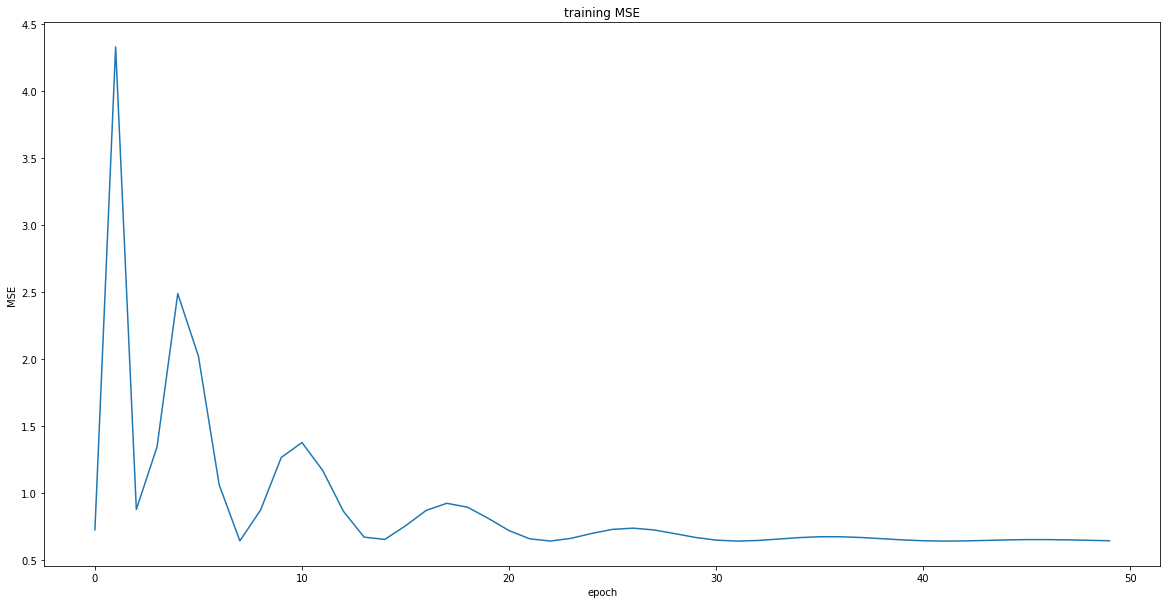

In [253]:
fig = plt.figure()
plt.plot(train_errors)
plt.title("training MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

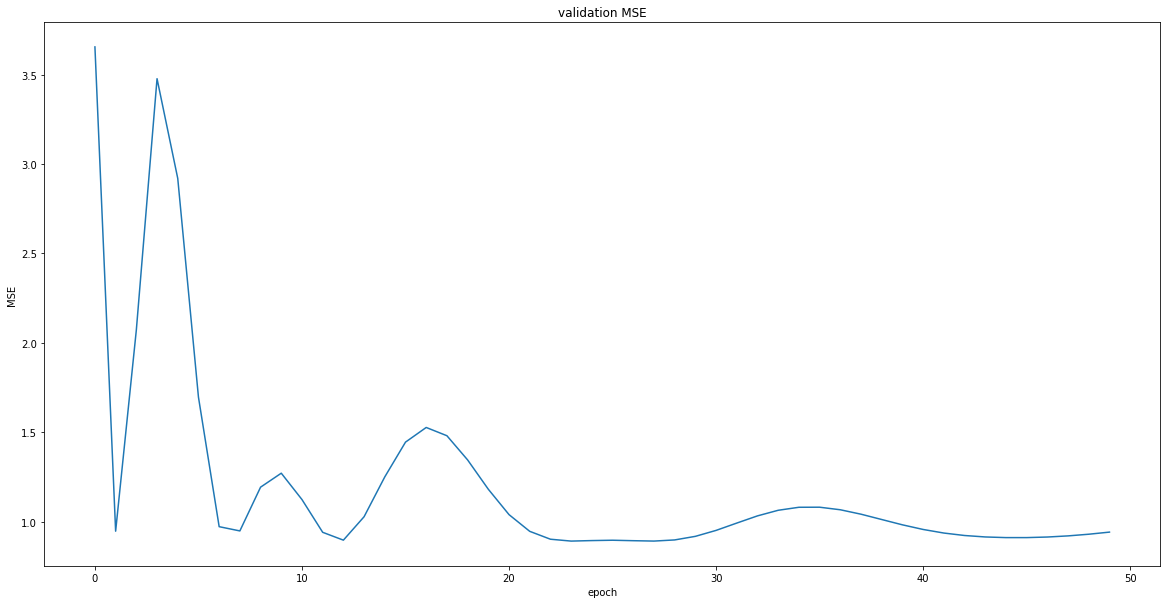

In [257]:
fig = plt.figure()
plt.plot(val_accuracy)
plt.title("validation MSE")
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
fig.savefig(figure_path+'val_MSE.png')

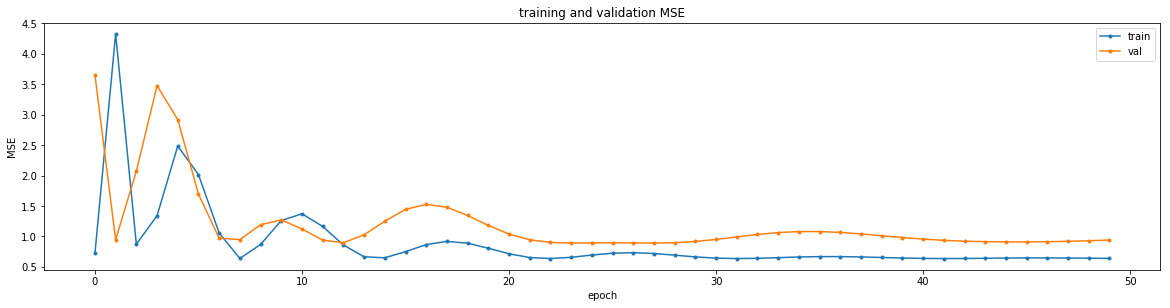

In [256]:
fig = plt.figure()
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.title("training and validation MSE")
#plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()
fig.savefig(figure_path+'train_val_MSE.png')

### Adam 5e-6 

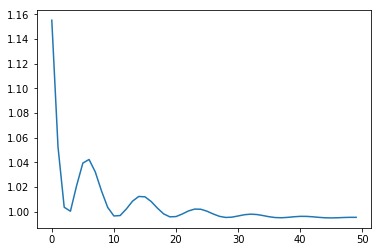

In [131]:
plt.plot(train_errors)

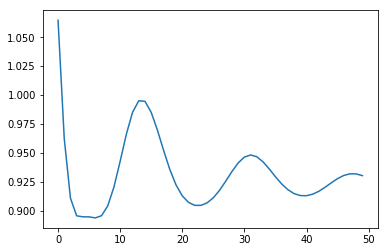

In [132]:
plt.plot(val_accuracy)

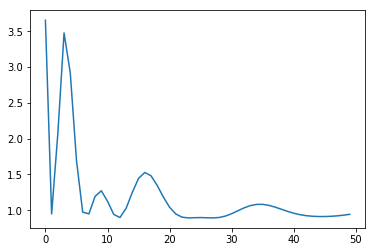

In [161]:
plt.plot(val_accuracy)

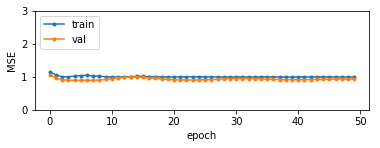

In [133]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### Shuffle data

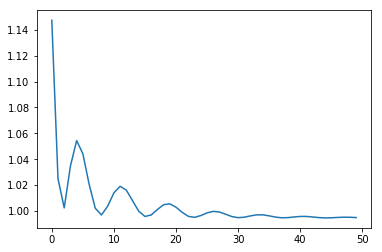

In [120]:
plt.plot(train_errors)

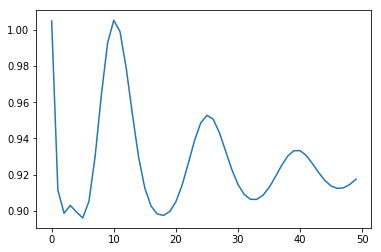

In [121]:
plt.plot(val_accuracy)

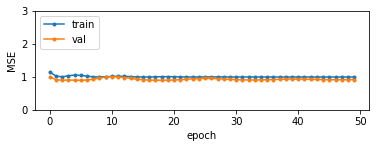

In [122]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### ADAM 1e-4

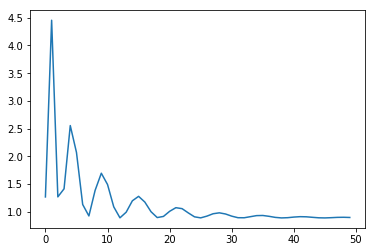

In [92]:
plt.plot(train_errors)

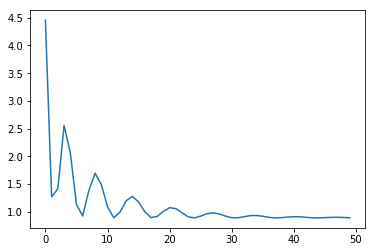

In [93]:
plt.plot(val_accuracy)

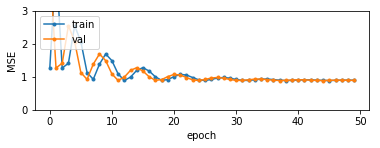

In [95]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.-')
plt.plot(val_accuracy, '.-')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### ADAM 1e-5

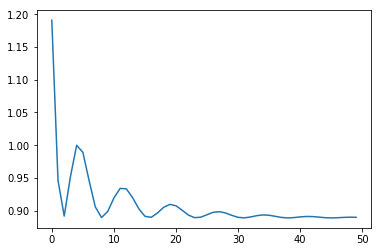

In [80]:
plt.plot(train_errors)

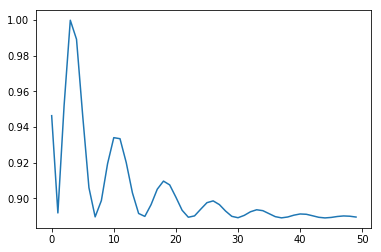

In [81]:
plt.plot(val_accuracy)

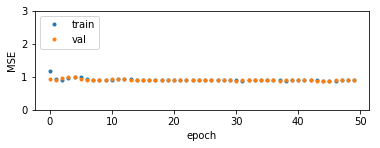

In [84]:
plt.subplot(2, 1, 2)
plt.plot(train_errors, '.')
plt.plot(val_accuracy, '.')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.show()

### SGD

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


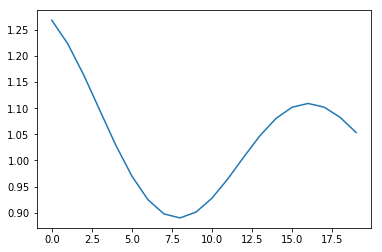

In [69]:
plt.plot(train_errors)

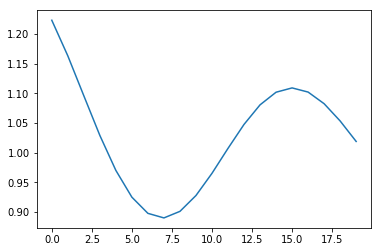

In [70]:
plt.plot(val_accuracy)

### OLD data set

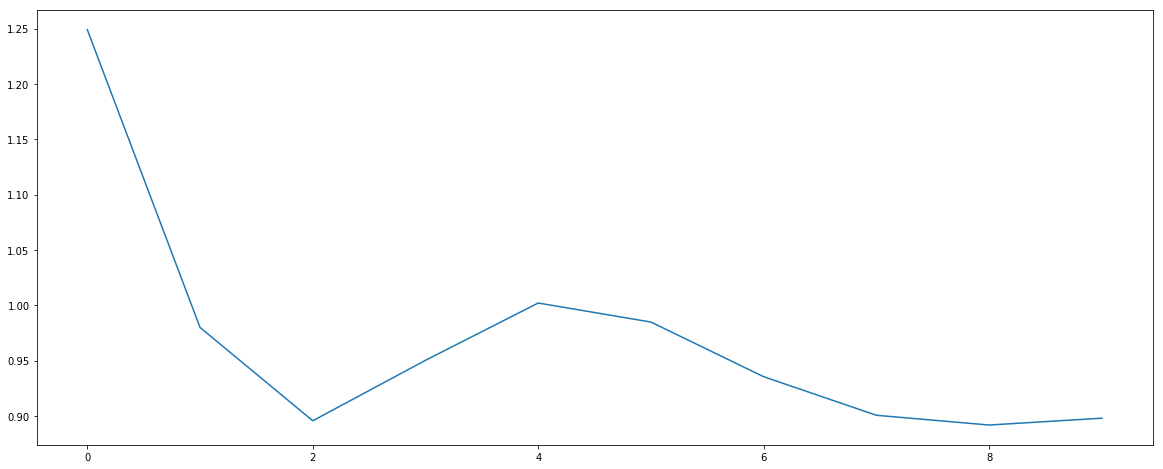

In [166]:
plt.plot(train_errors)

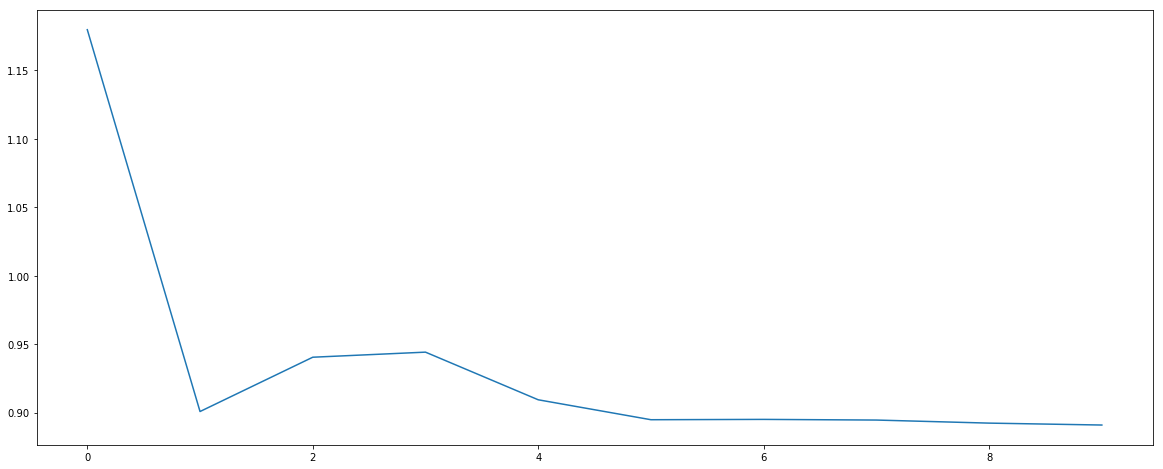

In [107]:
plt.plot(train_errors)

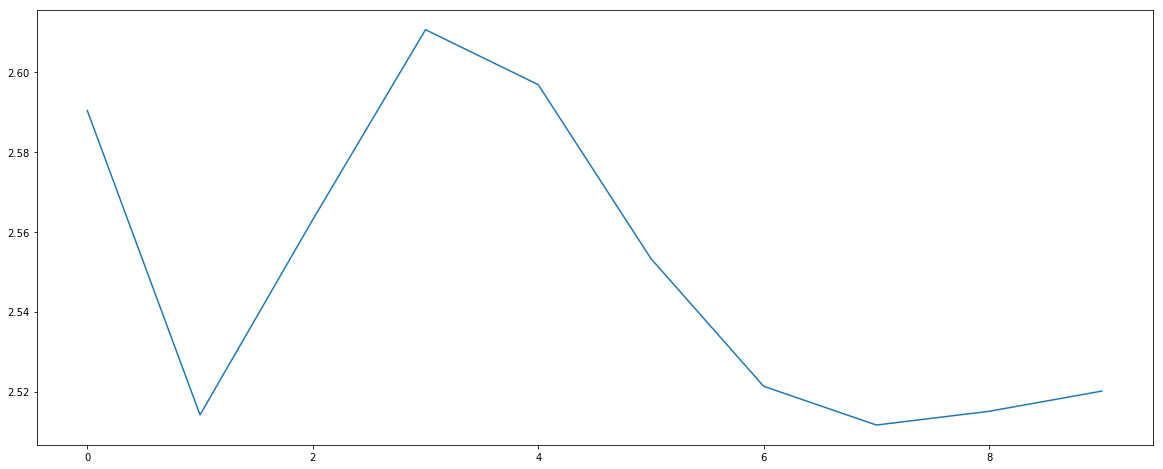

In [167]:
plt.plot(val_accuracy)

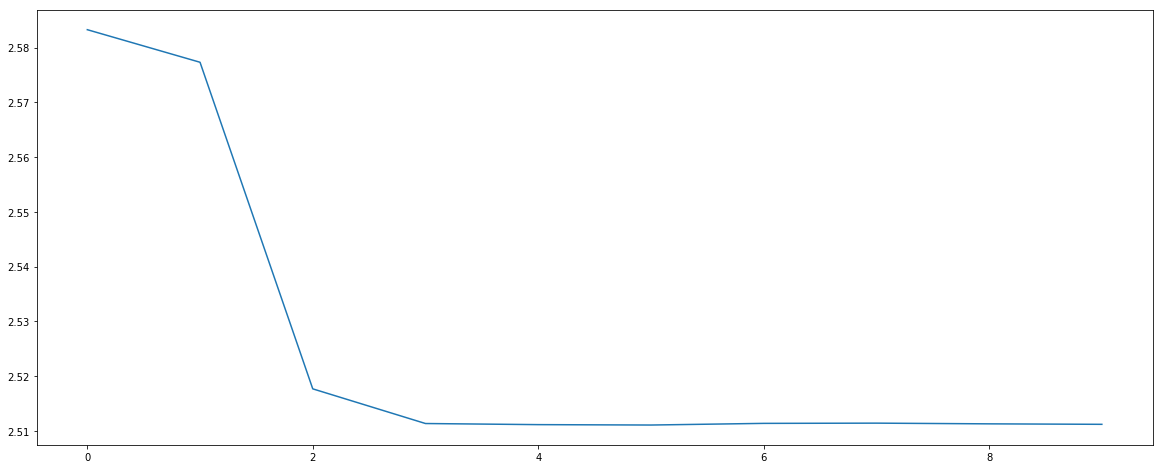

In [125]:
plt.plot(val_accuracy)

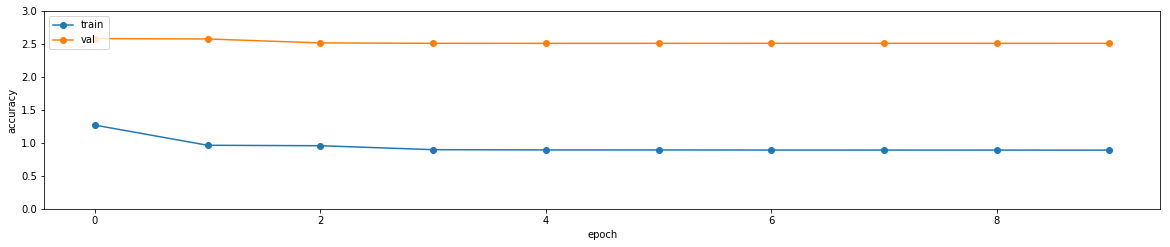

In [127]:

plt.subplot(2, 1, 2)
plt.plot(train_errors, '-o')
plt.plot(val_accuracy, '-o')
plt.ylim(0,3)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# plot prediction

In [174]:
np_prediction = prediction.cpu().numpy()

In [175]:
original_prediction = np_prediction*size_std

In [176]:
val_set['original_size_prediction'] = original_prediction
val_set['prediction'] = np_prediction

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [178]:
val_set[['well_id_1','original_hyst2_area_13','original_size_prediction']]

,well_id_1,original_hyst2_area_13,original_size_prediction
100,3637,551,467.536713
101,251,435,435.445740
102,1426,0,457.366241
103,717,0,393.622711
104,2777,39,434.425629
105,1791,3551,498.192963
106,1905,0,473.299469
107,527,0,447.178284
108,2732,117,448.164917
109,920,0,415.804688


In [177]:
val_set

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,hyst1_area_1,hyst2_area_1,...,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst1_area_13,hyst2_area_13,original_size_prediction,prediction
100,3637,1,113.0,7744,9,0,well3637_day01_well.png,3637,0.008391,0.000000,...,13,125.0,8649,817,551,well3637_day13_well.png,0.761672,0.433278,467.536713,0.367647
101,251,1,145.0,7740,29,0,well0251_day01_well.png,0251,0.027036,0.000000,...,13,139.0,7304,496,435,well0251_day13_well.png,0.462410,0.342062,435.445740,0.342412
102,1426,1,131.0,10028,1701,1338,well1426_day01_well.png,1426,1.585807,1.314720,...,13,136.0,7056,35,0,well1426_day13_well.png,0.032630,0.000000,457.366241,0.359649
103,717,1,140.0,7743,200,161,well0717_day01_well.png,0717,0.186456,0.158199,...,13,140.0,7565,216,0,well0717_day13_well.png,0.201372,0.000000,393.622711,0.309525
104,2777,1,119.0,9300,17,0,well2777_day01_well.png,2777,0.015849,0.000000,...,13,129.0,8835,480,39,well2777_day13_well.png,0.447494,0.030668,434.425629,0.341610
105,1791,1,125.0,7905,298,248,well1791_day01_well.png,1791,0.277819,0.243685,...,13,138.0,13054,4455,3551,well1791_day13_well.png,4.153303,2.792325,498.192963,0.391753
106,1905,1,134.0,7056,48,0,well1905_day01_well.png,1905,0.044749,0.000000,...,13,133.0,6806,118,0,well1905_day13_well.png,0.110009,0.000000,473.299469,0.372178
107,527,1,143.0,7826,89,0,well0527_day01_well.png,0527,0.082973,0.000000,...,13,149.0,9400,98,0,well0527_day13_well.png,0.091363,0.000000,447.178284,0.351638
108,2732,1,120.0,8277,62,0,well2732_day01_well.png,2732,0.057801,0.000000,...,13,129.0,8554,345,117,well2732_day13_well.png,0.321636,0.092003,448.164917,0.352414
109,920,1,138.0,7224,978,709,well0920_day01_well.png,0920,0.911769,0.696664,...,13,139.0,7480,36,0,well0920_day13_well.png,0.033562,0.000000,415.804688,0.326968


In [184]:
def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

def get_size_and_name(well_id,day_id,label):
    row = label[(label['well_id'] == well_id) & (label['day'] == day_id)]
    image_size = row['original_hyst2_area'].item()
    image_name = row['image_name'].item()
    return image_size, image_name    

def plot_image(well_id,day_id,label=label):
    image_size, image_name = get_size_and_name(well_id,day_id,label)
    well_image = imread(path+image_name)
    imshow_no_ax(well_image, normalize=False)
    plt.title('day'+str(day_id)+' size='+str(image_size))

def random_plot(label=label):
    max_well_id = label['well_id'].max()+1
    
    random_well_id = np.random.randint(0,max_well_id)
    print("well id "+ str(random_well_id))
    plt.subplot(1, 4, 1)
    plot_image(random_well_id,0)
    plt.subplot(1, 4, 2)
    plot_image(random_well_id,1)
    plt.subplot(1, 4, 3)
    plot_image(random_well_id,8)
    plt.subplot(1, 4, 4)
    plot_image(random_well_id,13)

In [190]:
random_well_id = np.random.choice(val_set.well_id_1)

In [203]:
random_well_id

3983

In [211]:
random_well_prediction = val_set.query("well_id_13 == %d"%random_well_id)['original_size_prediction']

In [219]:
val_set.query("well_id_13 == %d"%random_well_id)

,well_id_1,day_1,median_pixel_intensity_1,mw_area_shape_1,original_hyst1_area_1,original_hyst2_area_1,image_name_1,well_label,hyst1_area_1,hyst2_area_1,...,day_13,median_pixel_intensity_13,mw_area_shape_13,original_hyst1_area_13,original_hyst2_area_13,image_name_13,hyst1_area_13,hyst2_area_13,original_size_prediction,prediction
169,2493,1,120.0,8004,64,0,well2493_day01_well.png,2493,0.059666,0.0,...,13,131.0,8550,106,0,well2493_day13_well.png,0.098822,0.0,449.921814,0.353795


In [234]:
def random_plot_prediction():
    random_well_id = np.random.choice(val_set.well_id_1)
    random_well_prediction = val_set.query("well_id_13 == %d"%random_well_id)['original_size_prediction']
    fig = plt.figure()
    st = fig.suptitle("day13 size prediction : %d"%random_well_prediction, fontsize="x-large")    
    
    print("well id "+ str(random_well_id))
    plt.title('day13 size prediction')
    plt.subplot(1, 3, 1)
    plot_image(random_well_id,1)

    plt.subplot(1, 3, 2)
    plot_image(random_well_id,13)

    fig.savefig(figure_path+"well_%d_prediction.png"%random_well_id)


well id 3731


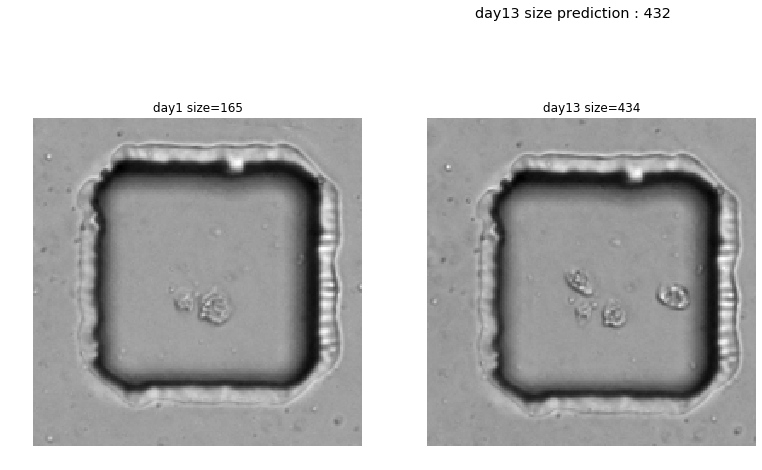

In [244]:
random_plot_prediction()

well id 2364


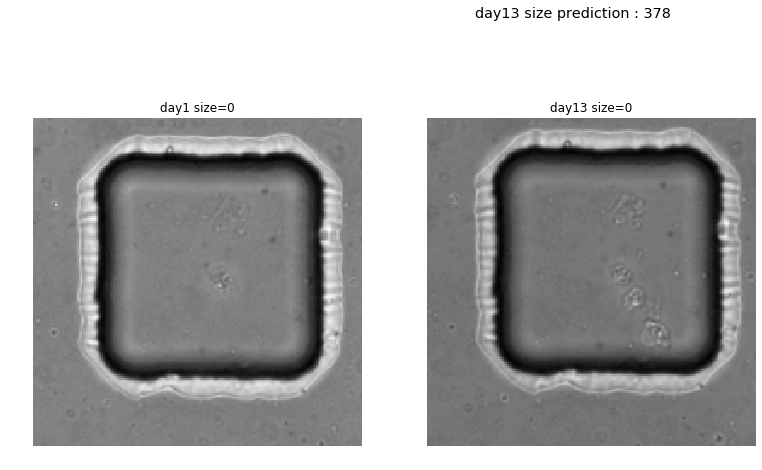

In [223]:
random_plot_prediction()

well id 3674


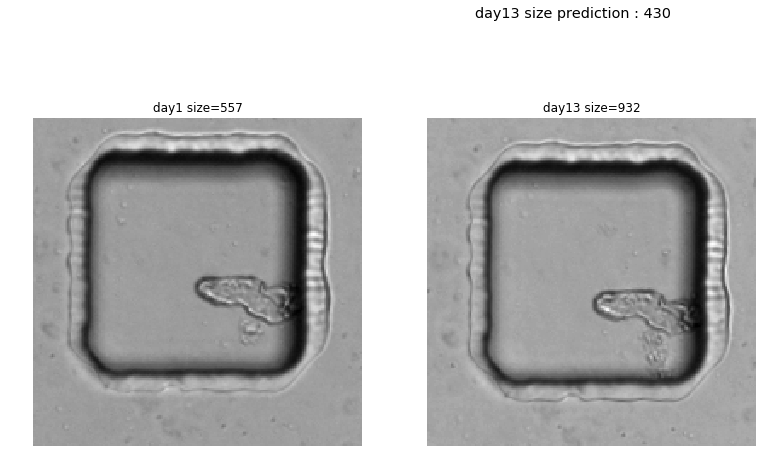

In [224]:
random_plot_prediction()

well id 1791


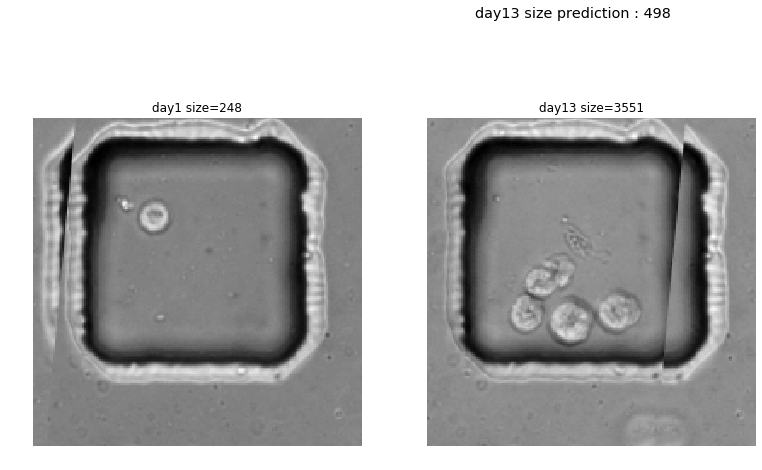

In [226]:
random_plot_prediction()

well id 2732


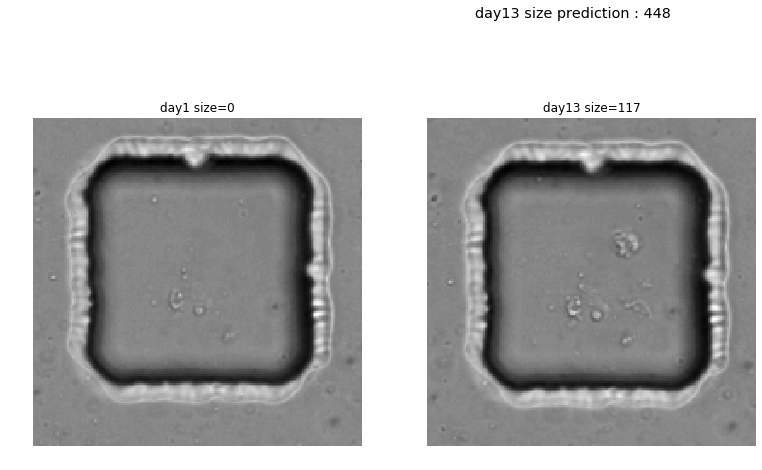

In [230]:
random_plot_prediction()

well id 4460


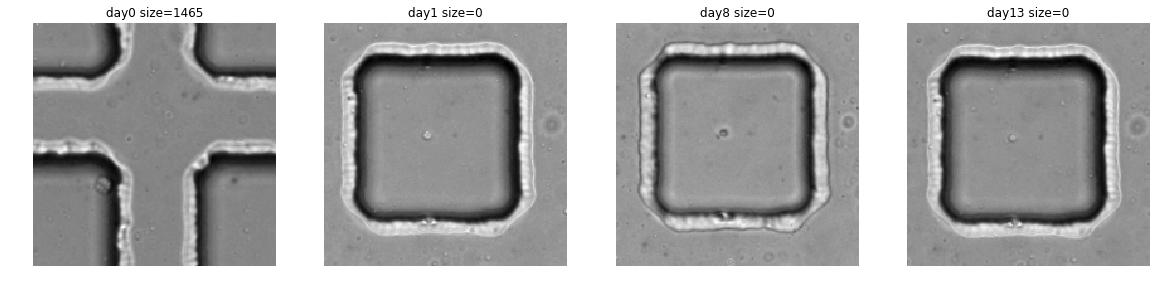

In [217]:
random_plot()